# Porous media segmentation based on image augmentation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import warnings

from matplotlib.pyplot import imshow
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.layers import Dropout, Add, Activation, Concatenate, Permute
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import layers

## Data processing

### Training & Devlopment set

In [14]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")

val_x = np.load("val_x.npy")
val_y = np.load("val_y.npy")

test_x = np.load("test_x.npy")
test_y = np.load("test_y.npy")

## U-net model

In [16]:
def Stem(x, filters): 
    x = layers.Conv2D(filters, (3,3), padding="same", strides=1, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(filters, (3,3), padding="same", strides=1, kernel_initializer="he_normal")(x)

    return x

def Res_Block(x, filters, s): 
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    
    # Down-sampling
    x = layers.Conv2D(filters, (3,3), padding="same", strides=s, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(filters, (3,3), padding="same", strides=1, kernel_initializer="he_normal")(x)

    return x

def Up_block(x, skip, filters): 
    x = layers.UpSampling2D((2, 2))(x)
    out = layers.concatenate([x, skip], axis=3)
    
    return out

input_layer = Input(shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3]))
# Entry block
stem = Stem(input_layer, 16) 
x = stem

# Encoder
for idx, filters in enumerate([32, 64, 128, 256]):  
    x = Res_Block(x, filters, 2) 

    if idx == 0:
        # 128 by 128
        conv1 = x
    elif idx == 1:
        # 64 by 64
        conv2 = x
    elif idx == 2:
        # 32 by 32
        conv3 = x
    elif idx == 3:
        # 16 by 16
        conv4 = x

# Bottleneck
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, (3,3), padding="same", strides=1, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, (3,3), padding="same", strides=1, kernel_initializer="he_normal")(x)

# Decoder
for idx, filters in enumerate([256, 128, 64, 32]):
    if idx == 0:
        x = Up_block(x, conv3, filters)    #32 by 32
        x = Res_Block(x, filters, 1) 
    elif idx == 1:
        x = Up_block(x, conv2, filters)    #64 by 64
        x = Res_Block(x, filters, 1) 
    elif idx == 2:
        x = Up_block(x, conv1, filters)    #128 by 128
        x = Res_Block(x, filters, 1) 
    elif idx == 3:
        x = Up_block(x, stem, filters)     #256 by 256
        x = Res_Block(x, filters, 1) 
                
# Channel-wise pooling
out = Conv2D(1, (1,1), activation='sigmoid', padding='same', kernel_initializer="he_normal")(x)

model = Model(input_layer, out)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 256, 256, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_57 (BatchN  (None, 256, 256, 16  64         ['conv2d_63[0][0]']              
 ormalization)                  )                                                           

## Try different loss function

#### - binary cross entropy
#### - L1 loss
#### - sparse categorical crossentropy


In [17]:
def loss_func(y_true, y_pred):
    loss = K.mean(K.abs(y_pred - y_true), axis=-1) + tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred) 
    
    return loss


In [18]:
# scc = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.compat.v1.losses.Reduction.NONE)
model.compile("adam", loss=loss_func)
history1=model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=100, batch_size=16, shuffle=True)

Epoch 1/100
80/80 [==============================] - 21s 221ms/step - loss: 0.3534 - val_loss: 975.7242
Epoch 2/100
80/80 [==============================] - 17s 211ms/step - loss: 0.2293 - val_loss: 20.8329
Epoch 3/100
80/80 [==============================] - 18s 225ms/step - loss: 0.1971 - val_loss: 4.6757
Epoch 4/100
80/80 [==============================] - 17s 211ms/step - loss: 0.1692 - val_loss: 0.2004
Epoch 5/100
80/80 [==============================] - 16s 202ms/step - loss: 0.1562 - val_loss: 0.2296
Epoch 6/100
80/80 [==============================] - 17s 211ms/step - loss: 0.1419 - val_loss: 0.3979
Epoch 7/100
80/80 [==============================] - 17s 211ms/step - loss: 0.1212 - val_loss: 0.2148
Epoch 8/100
80/80 [==============================] - 17s 211ms/step - loss: 0.1299 - val_loss: 0.2108
Epoch 9/100
80/80 [==============================] - 18s 223ms/step - loss: 0.1107 - val_loss: 0.2296
Epoch 10/100
80/80 [==============================] - 21s 257ms/step - loss: 0.

Text(0.5, 0, 'Epoch')

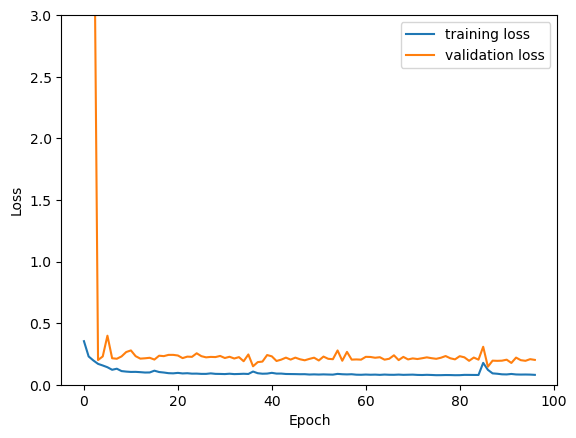

In [24]:
plt.figure()
outlier = 16
outlier2 = 38
outlier3 = 86
train_loss = history1.history['loss'][:outlier-1] + history1.history['loss'][outlier:outlier2-1] + history1.history['loss'][outlier2:outlier3-1] + history1.history['loss'][outlier3:]
val_loss = history1.history['val_loss'][:outlier-1] + history1.history['val_loss'][outlier:outlier2-1] + history1.history['val_loss'][outlier2:outlier3-1]+ history1.history['val_loss'][outlier3:]
plt.plot(train_loss,label="training loss")
plt.plot(val_loss,label="validation loss")
plt.ylim([0, 3])
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

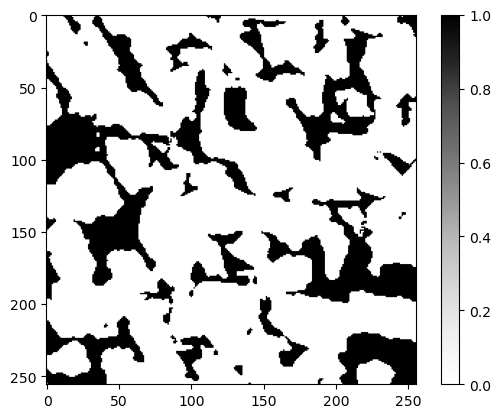

In [25]:
plt.imshow(test_y[12,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

In [26]:
testPred = model.predict(test_x)

16/16 [==============================] - 2s 97ms/step


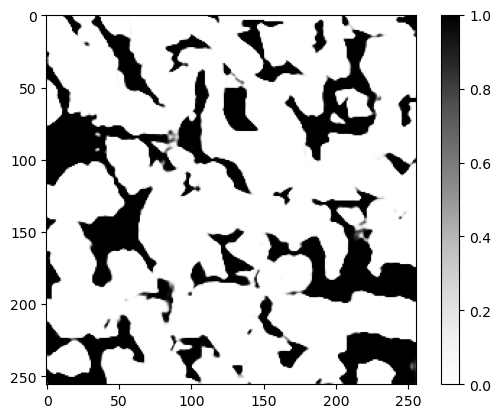

In [27]:
plt.imshow(testPred[12,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

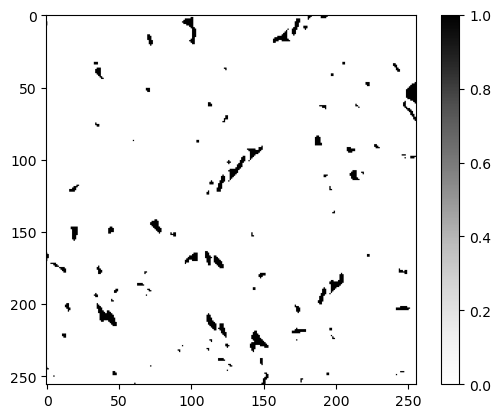

In [149]:
plt.imshow(test_y[7,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

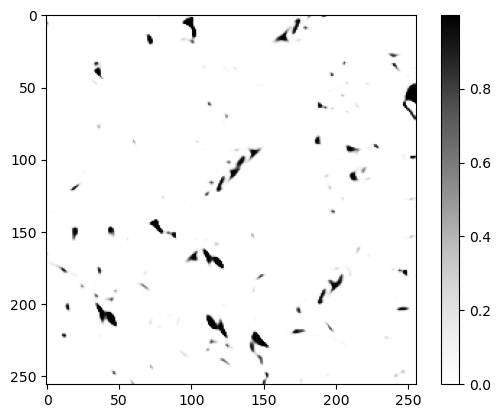

In [28]:
plt.imshow(testPred[7,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

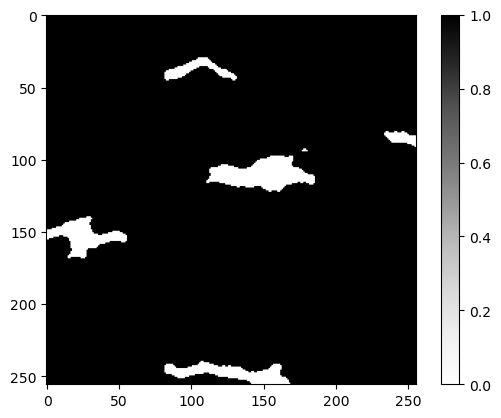

In [151]:
plt.imshow(test_y[15,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

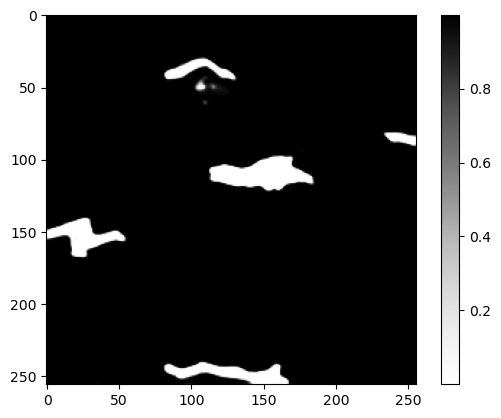

In [29]:
plt.imshow(testPred[15,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

In [30]:
def iou_coef(true, pred, smooth=1):
  intersection = K.sum(K.abs(true * pred))
  union = K.sum(true)+K.sum(pred)-intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou

iou_acc = 0

for i in range(22):
    test_y = tf.cast(test_y, tf.double)
    testPred = tf.cast(testPred, tf.double)
    iou_acc += iou_coef(test_y[i,:,:,0], testPred[i,:,:,0], smooth=1)
    
iou_acc = iou_acc/(i+1)

print(iou_acc)

tf.Tensor(0.7384029999726306, shape=(), dtype=float64)
